# Jun 6th, 2022 (results so far, prune, mg)

**Motivation**: $k=7$ and $k = 10$ look really good for Bold mg; and everything looks good for Ca.  Sadly I will have to miss showing $k=8$ for ca. <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from model.configuration import Config
from model.mouse import Mice
from analysis.group import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Prepare

In [2]:
mice = Mice(128)

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

In [3]:
task = 'rest'
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)

num_k, p = None, 20
perc = f'p{p}-sample'
props_base = {
    'kw_kmeans': {'n_init': 100},
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

### Ca2

In [4]:
pi_avg = {}
pi_all = {}
for kk in tqdm(range(4, 15, 1)):
    props_ca['num_k'] = kk
    gr_ca = Group(**props_ca).fit_group()
    pruned_ca = gr_ca.prune(thres=0.003, ci=0.95)
    pi_ca = gr_ca.align_post_prune(pruned_ca['pi_prune_run'])[0]
    pi_all[kk] = pi_ca
    pi_avg[f'ca2-k{kk}(pr95)\nb={b}'.replace(' ', '')] = avg(pi_ca)
    
# sort
d2p = pi_avg.copy()
for i in range(len(pi_avg)):
    lbl, x = list(pi_avg.items())[i]
    if i == 0:
        continue
    src = list(d2p.values())[i - 1]
    gmap = find_best_mappings(
        centroids=src,
        data={0: x},
        match_metric='cosine',
        global_order='infer',
    )[0]
    ids = list(gmap.values())
    ids = ids + list(np.delete(range(len(x)), ids))
    d2p[lbl] = x[ids]

  0%|          | 0/11 [00:00<?, ?it/s]

In [5]:
gr_ca.fit_meta

{
    'time_start': '2022_06_06_12-26',
    'min_runs_thresh': 0.6,
    'min_node_thresh': 0.7,
    'best_node_freq_q': 0.93,
    'num_total_runs': 110,
    'fraction_accepted_runs': 0.6727272727272727,
    'fraction_good_nodes': 0.7368421052631579,
    'time_end': '2022_06_06_12-29'
}

In [6]:
gr_ca.kw_kmeans

{'n_init': 100, 'max_iter': 300, 'tol': 0.0001}

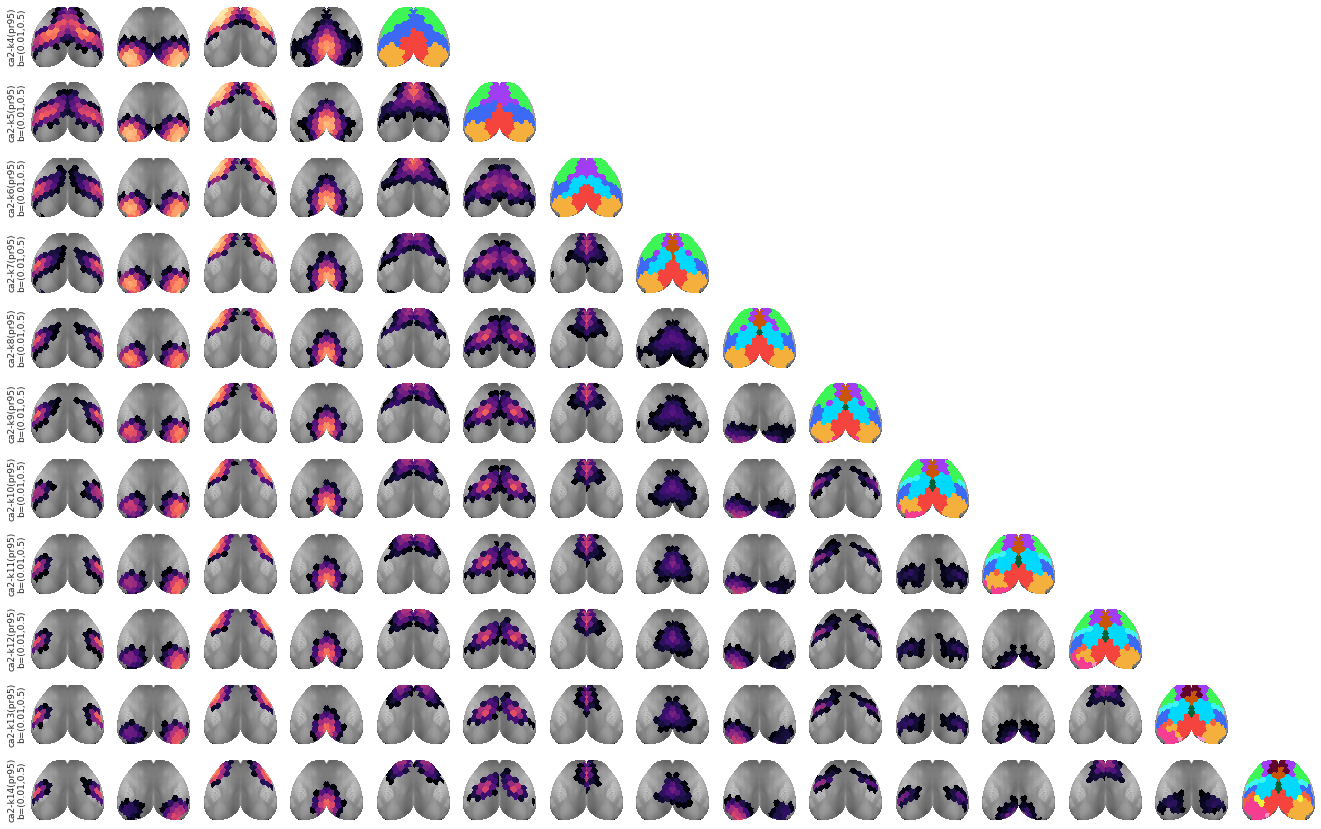

In [7]:
_ = gr_ca.show(d2p, figsize=(23, 15))

In [8]:
h_all = []
for kk, x in pi_all.items():
    h = sp_stats.entropy(bn.nanmean(x, -3), axis=-2) / np.log(x.shape[-2])
    h_all.append(np.expand_dims(h, 0))
h_all = np.concatenate(h_all)
h_avg = avg(h_all, 1, 1)

h_all.shape, h_avg.shape

((11, 10, 3, 4, 152), (11, 152))

In [9]:
np.nanmin(h_avg), np.nanmax(h_avg)

(0.06061408157035186, 0.7033656248943743)

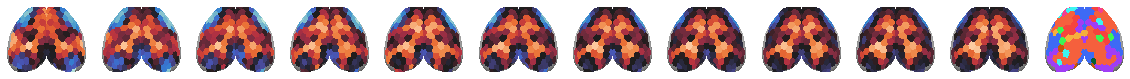

In [10]:
_ = gr_ca.show(
    h_avg,
    vmin=np.nanmin(h_avg),
    vmax=np.nanmax(h_avg),
    figsize=(20, 4),
    cmap='icefire',
)

In [11]:
sim_h = dist2sim(sp_dist.squareform(sp_dist.pdist(
    h_avg, metric='correlation')))

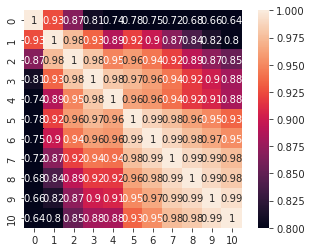

In [12]:
sns.heatmap(
    sim_h,
    vmin=0.8,
    vmax=1.0,
    square=True,
    annot=True,
    fmt='.2g',
)
plt.show()

### Bold

In [13]:
pi_avg = {}
pi_all = {}
for kk in tqdm(range(4, 15)):
    props_bo['num_k'] = kk
    gr_bo = Group(**props_bo).fit_group()
    pruned_bo = gr_bo.prune(thres=0.003, ci=0.95)
    pi_bo = gr_bo.align_post_prune(pruned_bo['pi_prune_run'])[0]
    pi_all[kk] = pi_bo
    pi_avg[f'bo-k{kk}(pr95)\nb={b}'.replace(' ', '')] = avg(pi_bo)
    
# sort
d2p = pi_avg.copy()
for i in range(len(pi_avg)):
    lbl, x = list(pi_avg.items())[i]
    if i == 0:
        continue
    src = list(d2p.values())[i - 1]
    gmap = find_best_mappings(
        centroids=src,
        data={0: x},
        match_metric='cosine',
        global_order='infer',
    )[0]
    ids = list(gmap.values())
    ids = ids + list(np.delete(range(len(x)), ids))
    d2p[lbl] = x[ids]

  0%|          | 0/11 [00:00<?, ?it/s]

In [14]:
gr_bo.fit_meta

{
    'time_start': '2022_06_04_12-32',
    'min_runs_thresh': 0.75,
    'min_node_thresh': 0.85,
    'best_node_freq_q': 0.985,
    'num_total_runs': 114,
    'fraction_accepted_runs': 0.8859649122807017,
    'fraction_good_nodes': 0.8618421052631579,
    'time_end': '2022_06_04_12-46'
}

In [15]:
gr_ca.kw_kmeans

{'n_init': 100, 'max_iter': 300, 'tol': 0.0001}

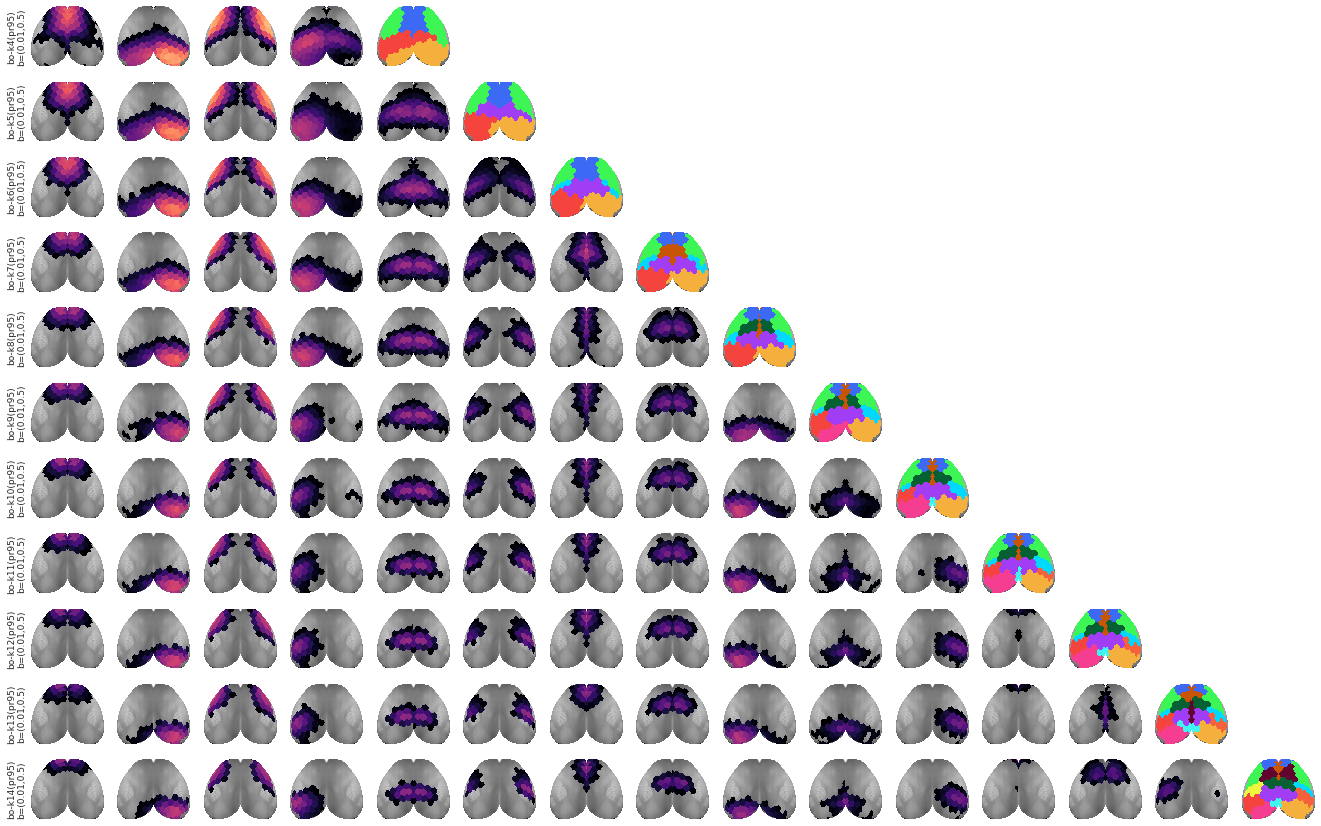

In [16]:
_ = gr_bo.show(d2p, figsize=(23, 15))

In [17]:
h_all = []
for kk, x in pi_all.items():
    h = sp_stats.entropy(bn.nanmean(x, -3), axis=-2) / np.log(x.shape[-2])
    h_all.append(np.expand_dims(h, 0))
h_all = np.concatenate(h_all)
h_avg = avg(h_all, 1, 1)

h_all.shape, h_avg.shape

((11, 10, 3, 4, 152), (11, 152))

In [18]:
np.nanmin(h_avg), np.nanmax(h_avg)

(0.27331670476811226, 0.7710337355398118)

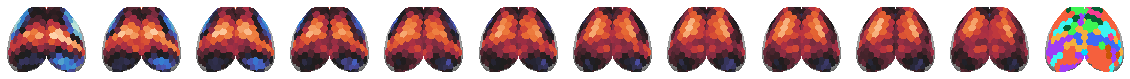

In [19]:
_ = gr_ca.show(
    h_avg,
    vmin=np.nanmin(h_avg),
    vmax=np.nanmax(h_avg),
    figsize=(20, 4),
    cmap='icefire',
)

In [20]:
sim_h = dist2sim(sp_dist.squareform(sp_dist.pdist(
    h_avg, metric='correlation')))

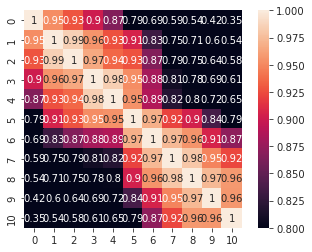

In [21]:
sns.heatmap(
    sim_h,
    vmin=0.8,
    vmax=1.0,
    square=True,
    annot=True,
    fmt='.2g',
)
plt.show()

### Bold (mg)

In [4]:
pi_avg = {}
pi_all = {}
for kk in tqdm(range(4, 15)):
    props_bo['num_k'] = kk
    gr_bo = Group(**props_bo).fit_group()
    pruned_bo = gr_bo.prune(thres=0.003, ci=0.95)
    pi_bo = gr_bo.align_post_prune(pruned_bo['pi_prune_run'])[0]
    gr_bo.run_pi = pi_bo
    gr_bo._merge_vis(0.1)
    
    pi_all[kk] = gr_bo.run_pi
    pi_avg[f'bo-k{kk-1}\n(pr95-mg1)\nb={b}'.replace(' ', '')] = avg(gr_bo.run_pi)
    
# sort
d2p = pi_avg.copy()
for i in range(len(pi_avg)):
    lbl, x = list(pi_avg.items())[i]
    if i == 0:
        continue
    src = list(d2p.values())[i - 1]
    gmap = find_best_mappings(
        centroids=src,
        data={0: x},
        match_metric='cosine',
        global_order='infer',
    )[0]
    ids = list(gmap.values())
    ids = ids + list(np.delete(range(len(x)), ids))
    d2p[lbl] = x[ids]

  0%|          | 0/11 [00:00<?, ?it/s]

In [5]:
gr_bo.fit_meta

{
    'time_start': '2022_06_04_12-32',
    'min_runs_thresh': 0.75,
    'min_node_thresh': 0.85,
    'best_node_freq_q': 0.985,
    'num_total_runs': 114,
    'fraction_accepted_runs': 0.8859649122807017,
    'fraction_good_nodes': 0.8618421052631579,
    'time_end': '2022_06_04_12-46'
}

In [7]:
gr_bo.kw_kmeans

{'n_init': 100, 'max_iter': 300, 'tol': 0.0001}

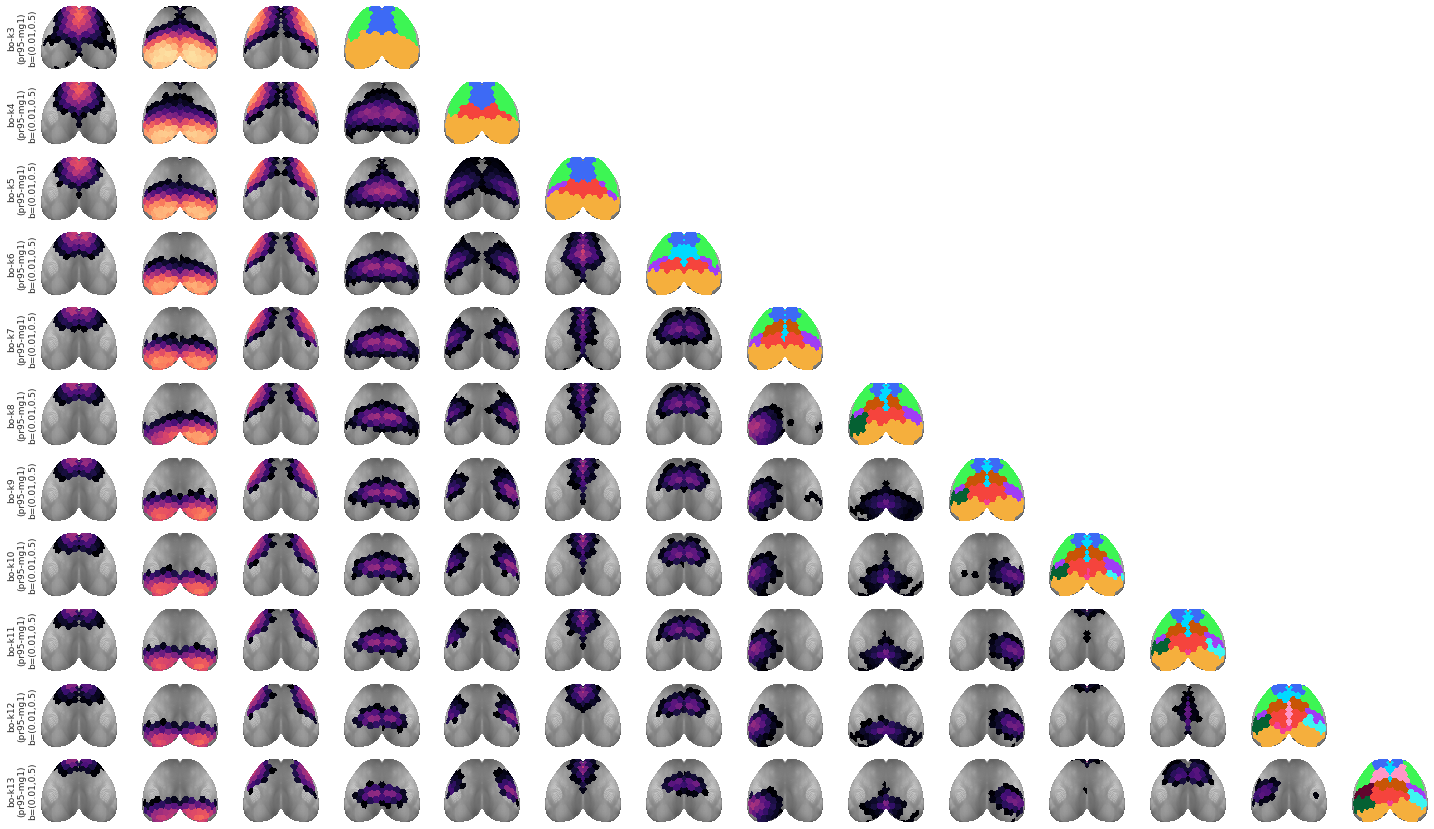

In [8]:
_ = gr_bo.show(d2p, figsize=(25, 15))

## Pr 95

In [5]:
d2p = {}

# BOLD prune 95
gr_bo = Group(**props_bo).fit_group()
pruned_bo = gr_bo.prune(thres=0.003, ci=0.95)
pi_bo = gr_bo.align_post_prune(pruned_bo['pi_prune_run'])[0]
pi_run_bo = bn.nanmean(pi_bo, -3)
gr_bo.avg(pi_bo)
d2p['bold(pr95)'] = gr_bo.trim2d(gr_bo.project_vec())

gr_ca = Group(**props_ca).fit_group()
pruned_ca = gr_ca.prune(thres=0.003, ci=0.95)
pi_ca = gr_ca.align_post_prune(pruned_ca['pi_prune_run'])[0]
pi_run_ca = bn.nanmean(pi_ca, -3)
gr_ca.avg(pi_ca)
d2p[f'ca2(pr95)\nb={b}'.replace(' ', '')] = gr_ca.trim2d(gr_ca.project_vec())

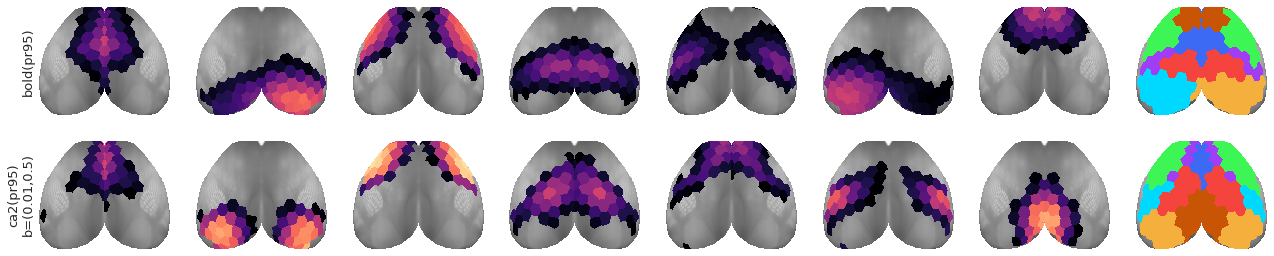

In [6]:
_ = quick_show(d2p, vmin=0.1, vmax=1.0, figsize=(22, 4.5), ylabel_fontsize=13)

## Histogram plot

In [7]:
bins = np.linspace(0.1, 1, 10)
bins

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [8]:
cut_bo = cut_data(
    data=pi_bo.reshape(-1, *pi_bo.shape[-2:]),
    bins=bins,
    oc_only=True,
)[0].reshape(*pi_bo.shape[:4], pi_bo.shape[-2], -1)
cut_avg_bo = apply_fn(cut_bo)

cut_ca = cut_data(
    data=pi_ca.reshape(-1, *pi_ca.shape[-2:]),
    bins=bins,
    oc_only=True,
)[0].reshape(*pi_ca.shape[:4], pi_ca.shape[-2], -1)
cut_avg_ca = apply_fn(cut_ca)
cut_ca.shape, cut_avg_ca.shape

cut_bo.shape, cut_avg_bo.shape

((10, 3, 4, 500, 7, 9), (7, 9))

In [9]:
colors = get_cluster_cmap(range(gr_bo.num_k), True)[1]

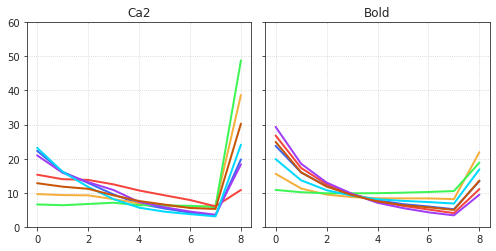

In [10]:
fig, axes = create_figure(1, 2, (7, 3.6), 'all', 'all')

for i, c in enumerate(colors):
    axes[0].plot(cut_avg_ca[i], color=c, lw=2)
    axes[1].plot(cut_avg_bo[i], color=c, lw=2)
    axes[0].set_title('Ca2')
    axes[1].set_title('Bold')
axes[-1].set_ylim(0, 60)
add_grid(axes)
plt.show()

## Entropy plot

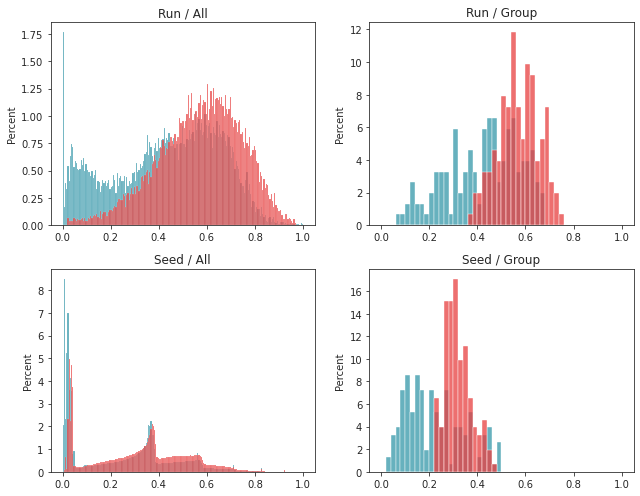

In [11]:
fig, axes = create_figure(2, 2, (9, 7))

h_ca = sp_stats.entropy(pi_run_ca, axis=-2) / np.log(gr_ca.num_k)
h_bo = sp_stats.entropy(pi_run_bo, axis=-2) / np.log(gr_bo.num_k)
h_ca_avg = apply_fn(h_ca, 1)
h_bo_avg = apply_fn(h_bo, 1)

sns.histplot(
    h_ca[np.isfinite(h_ca)],
    bins=np.linspace(0, 1, 201),
    color=pal['ca2'],
    stat='percent',
    ax=axes[0, 0],
)
sns.histplot(
    h_bo[np.isfinite(h_bo)],
    bins=np.linspace(0, 1, 201),
    color=pal['bold-lite'],
    stat='percent',
    ax=axes[0, 0],
)
sns.histplot(
    h_ca_avg[np.isfinite(h_ca_avg)],
    bins=np.linspace(0, 1, 51),
    color=pal['ca2'],
    stat='percent',
    ax=axes[0, 1],
)
sns.histplot(
    h_bo_avg[np.isfinite(h_bo_avg)],
    bins=np.linspace(0, 1, 51),
    color=pal['bold-lite'],
    stat='percent',
    ax=axes[0, 1],
)
axes[0, 0].set_title('Run / All')
axes[0, 1].set_title('Run / Group')


h_ca = sp_stats.entropy(pi_ca, axis=-2) / np.log(gr_ca.num_k)
h_bo = sp_stats.entropy(pi_bo, axis=-2) / np.log(gr_bo.num_k)
h_ca_avg = apply_fn(h_ca, 1)
h_bo_avg = apply_fn(h_bo, 1)

sns.histplot(
    h_ca[np.isfinite(h_ca)],
    bins=np.linspace(0, 1, 201),
    color=pal['ca2'],
    stat='percent',
    ax=axes[1, 0],
)
sns.histplot(
    h_bo[np.isfinite(h_bo)],
    bins=np.linspace(0, 1, 201),
    color=pal['bold-lite'],
    stat='percent',
    ax=axes[1, 0],
)
sns.histplot(
    h_ca_avg[np.isfinite(h_ca_avg)],
    bins=np.linspace(0, 1, 51),
    color=pal['ca2'],
    stat='percent',
    ax=axes[1, 1],
)
sns.histplot(
    h_bo_avg[np.isfinite(h_bo_avg)],
    bins=np.linspace(0, 1, 51),
    color=pal['bold-lite'],
    stat='percent',
    ax=axes[1, 1],
)
axes[1, 0].set_title('Seed / All')
axes[1, 1].set_title('Seed / Group')

#for ax in axes.flat:
#    ax.legend()
plt.show()

In [12]:
bins = np.linspace(0, 1, 51)
xx = (bins[:-1] + bins[1:]) / 2

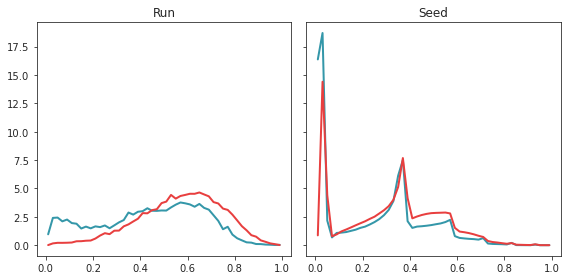

In [13]:
fig, axes = create_figure(1, 2, (8, 4), 'all', 'all')


h_ca = sp_stats.entropy(pi_run_ca, axis=-2) / np.log(gr_ca.num_k)
h_bo = sp_stats.entropy(pi_run_bo, axis=-2) / np.log(gr_bo.num_k)

cut_ca = cut_data(
    data=h_ca.reshape(-1, 1, h_ca.shape[-1]),
    bins=bins,
    oc_only=True,
)[0].reshape(*h_ca.shape[:3], -1)
cut_avg_ca = apply_fn(cut_ca, 1)

cut_bo = cut_data(
    data=h_bo.reshape(-1, 1, h_bo.shape[-1]),
    bins=bins,
    oc_only=True,
)[0].reshape(*h_bo.shape[:3], -1)
cut_avg_bo = apply_fn(cut_bo, 1)

axes[0].plot(xx, cut_avg_ca, color=pal['ca2'], lw=2)
axes[0].plot(xx, cut_avg_bo, color=pal['bold-lite'], lw=2)
axes[0].set_title('Run')


h_ca = sp_stats.entropy(pi_ca, axis=-2) / np.log(gr_ca.num_k)
h_bo = sp_stats.entropy(pi_bo, axis=-2) / np.log(gr_bo.num_k)

cut_ca = cut_data(
    data=h_ca.reshape(-1, 1, h_ca.shape[-1]),
    bins=bins,
    oc_only=True,
)[0].reshape(*h_ca.shape[:4], -1)
cut_avg_ca = apply_fn(cut_ca, 1)

cut_bo = cut_data(
    data=h_bo.reshape(-1, 1, h_bo.shape[-1]),
    bins=bins,
    oc_only=True,
)[0].reshape(*h_bo.shape[:4], -1)
cut_avg_bo = apply_fn(cut_bo, 1)

axes[1].plot(xx, cut_avg_ca, color=pal['ca2'], lw=2)
axes[1].plot(xx, cut_avg_bo, color=pal['bold-lite'], lw=2)
axes[1].set_title('Seed')
plt.show()

## Pr 99

In [14]:
d2p = {}

# BOLD prune 95
gr_bo = Group(**props_bo).fit_group()
pruned_bo = gr_bo.prune(thres=0.01, ci=0.99)
pi_bo = gr_bo.align_post_prune(pruned_bo['pi_prune_run'])[0]
pi_run_bo = bn.nanmean(pi_bo, -3)
gr_bo.avg(pi_bo)
d2p['bold(pr95)'] = gr_bo.trim2d(gr_bo.project_vec())

gr_ca = Group(**props_ca).fit_group()
pruned_ca = gr_ca.prune(thres=0.003, ci=0.95)
pi_ca = gr_ca.align_post_prune(pruned_ca['pi_prune_run'])[0]
pi_run_ca = bn.nanmean(pi_ca, -3)
gr_ca.avg(pi_ca)
d2p[f'ca2(pr95)\nb={b}'.replace(' ', '')] = gr_ca.trim2d(gr_ca.project_vec())

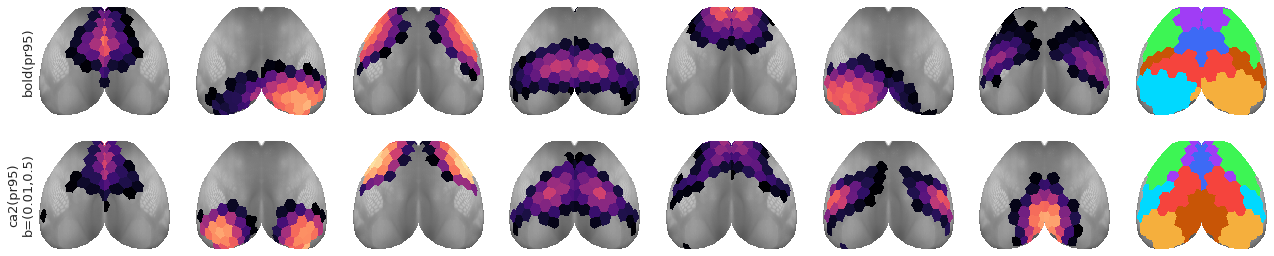

In [15]:
_ = quick_show(d2p, vmin=0.1, vmax=1.0, figsize=(22, 4.5), ylabel_fontsize=13)

## Histogram plot

In [16]:
bins = np.linspace(0.1, 1, 10)
bins

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [17]:
cut_bo = cut_data(
    data=pi_bo.reshape(-1, *pi_bo.shape[-2:]),
    bins=bins,
    oc_only=True,
)[0].reshape(*pi_bo.shape[:4], pi_bo.shape[-2], -1)
cut_avg_bo = apply_fn(cut_bo)

cut_ca = cut_data(
    data=pi_ca.reshape(-1, *pi_ca.shape[-2:]),
    bins=bins,
    oc_only=True,
)[0].reshape(*pi_ca.shape[:4], pi_ca.shape[-2], -1)
cut_avg_ca = apply_fn(cut_ca)
cut_ca.shape, cut_avg_ca.shape

cut_bo.shape, cut_avg_bo.shape

((10, 3, 4, 500, 7, 9), (7, 9))

In [18]:
colors = get_cluster_cmap(range(gr_bo.num_k), True)[1]

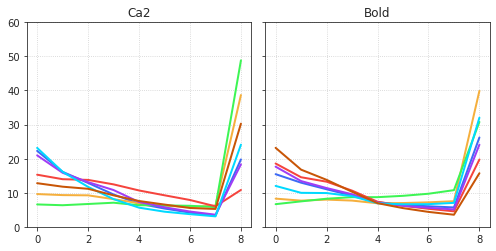

In [19]:
fig, axes = create_figure(1, 2, (7, 3.6), 'all', 'all')

for i, c in enumerate(colors):
    axes[0].plot(cut_avg_ca[i], color=c, lw=2)
    axes[1].plot(cut_avg_bo[i], color=c, lw=2)
    axes[0].set_title('Ca2')
    axes[1].set_title('Bold')
axes[-1].set_ylim(0, 60)
add_grid(axes)
plt.show()

## Entropy plot

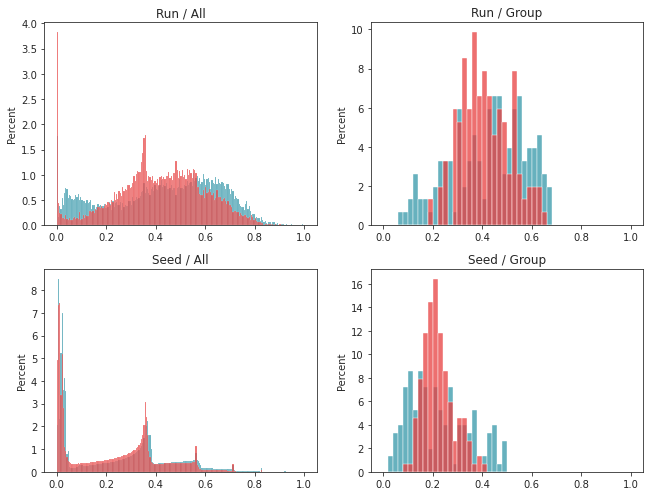

In [20]:
fig, axes = create_figure(2, 2, (9, 7))

h_ca = sp_stats.entropy(pi_run_ca, axis=-2) / np.log(gr_ca.num_k)
h_bo = sp_stats.entropy(pi_run_bo, axis=-2) / np.log(gr_bo.num_k)
h_ca_avg = apply_fn(h_ca, 1)
h_bo_avg = apply_fn(h_bo, 1)

sns.histplot(
    h_ca[np.isfinite(h_ca)],
    bins=np.linspace(0, 1, 201),
    color=pal['ca2'],
    stat='percent',
    ax=axes[0, 0],
)
sns.histplot(
    h_bo[np.isfinite(h_bo)],
    bins=np.linspace(0, 1, 201),
    color=pal['bold-lite'],
    stat='percent',
    ax=axes[0, 0],
)
sns.histplot(
    h_ca_avg[np.isfinite(h_ca_avg)],
    bins=np.linspace(0, 1, 51),
    color=pal['ca2'],
    stat='percent',
    ax=axes[0, 1],
)
sns.histplot(
    h_bo_avg[np.isfinite(h_bo_avg)],
    bins=np.linspace(0, 1, 51),
    color=pal['bold-lite'],
    stat='percent',
    ax=axes[0, 1],
)
axes[0, 0].set_title('Run / All')
axes[0, 1].set_title('Run / Group')


h_ca = sp_stats.entropy(pi_ca, axis=-2) / np.log(gr_ca.num_k)
h_bo = sp_stats.entropy(pi_bo, axis=-2) / np.log(gr_bo.num_k)
h_ca_avg = apply_fn(h_ca, 1)
h_bo_avg = apply_fn(h_bo, 1)

sns.histplot(
    h_ca[np.isfinite(h_ca)],
    bins=np.linspace(0, 1, 201),
    color=pal['ca2'],
    stat='percent',
    ax=axes[1, 0],
)
sns.histplot(
    h_bo[np.isfinite(h_bo)],
    bins=np.linspace(0, 1, 201),
    color=pal['bold-lite'],
    stat='percent',
    ax=axes[1, 0],
)
sns.histplot(
    h_ca_avg[np.isfinite(h_ca_avg)],
    bins=np.linspace(0, 1, 51),
    color=pal['ca2'],
    stat='percent',
    ax=axes[1, 1],
)
sns.histplot(
    h_bo_avg[np.isfinite(h_bo_avg)],
    bins=np.linspace(0, 1, 51),
    color=pal['bold-lite'],
    stat='percent',
    ax=axes[1, 1],
)
axes[1, 0].set_title('Seed / All')
axes[1, 1].set_title('Seed / Group')

#for ax in axes.flat:
#    ax.legend()
plt.show()

In [21]:
bins = np.linspace(0, 1, 51)
xx = (bins[:-1] + bins[1:]) / 2

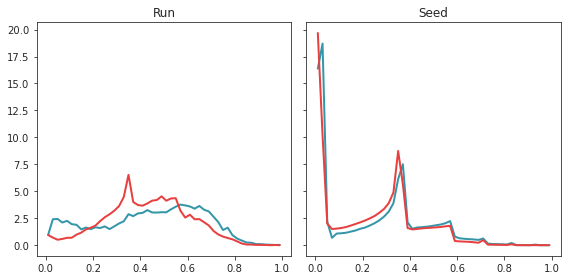

In [22]:
fig, axes = create_figure(1, 2, (8, 4), 'all', 'all')


h_ca = sp_stats.entropy(pi_run_ca, axis=-2) / np.log(gr_ca.num_k)
h_bo = sp_stats.entropy(pi_run_bo, axis=-2) / np.log(gr_bo.num_k)

cut_ca = cut_data(
    data=h_ca.reshape(-1, 1, h_ca.shape[-1]),
    bins=bins,
    oc_only=True,
)[0].reshape(*h_ca.shape[:3], -1)
cut_avg_ca = apply_fn(cut_ca, 1)

cut_bo = cut_data(
    data=h_bo.reshape(-1, 1, h_bo.shape[-1]),
    bins=bins,
    oc_only=True,
)[0].reshape(*h_bo.shape[:3], -1)
cut_avg_bo = apply_fn(cut_bo, 1)

axes[0].plot(xx, cut_avg_ca, color=pal['ca2'], lw=2)
axes[0].plot(xx, cut_avg_bo, color=pal['bold-lite'], lw=2)
axes[0].set_title('Run')


h_ca = sp_stats.entropy(pi_ca, axis=-2) / np.log(gr_ca.num_k)
h_bo = sp_stats.entropy(pi_bo, axis=-2) / np.log(gr_bo.num_k)

cut_ca = cut_data(
    data=h_ca.reshape(-1, 1, h_ca.shape[-1]),
    bins=bins,
    oc_only=True,
)[0].reshape(*h_ca.shape[:4], -1)
cut_avg_ca = apply_fn(cut_ca, 1)

cut_bo = cut_data(
    data=h_bo.reshape(-1, 1, h_bo.shape[-1]),
    bins=bins,
    oc_only=True,
)[0].reshape(*h_bo.shape[:4], -1)
cut_avg_bo = apply_fn(cut_bo, 1)

axes[1].plot(xx, cut_avg_ca, color=pal['ca2'], lw=2)
axes[1].plot(xx, cut_avg_bo, color=pal['bold-lite'], lw=2)
axes[1].set_title('Seed')
plt.show()

## Corr analysis

In [38]:
d2p = {}
ent_run = {}
ent_grp = {}

kk = 7
props_ca['num_k'] = kk
gr_ca = Group(**props_ca).fit_group()
pruned_ca = gr_ca.prune(thres=0.003, ci=0.95)
pi_ca = gr_ca.align_post_prune(pruned_ca['pi_prune_run'])[0]
pi_run_ca = bn.nanmean(pi_ca, -3)

h = sp_stats.entropy(pi_run_ca, axis=-2) / np.log(gr_ca.num_k)
ent_run[kk] = h
ent_grp[kk] = apply_fn(h, 1)

gr_ca.avg(pi_ca)
d2p[f'ca2-k7(pr95)\nb={b}'.replace(' ', '')] = gr_ca.trim2d(gr_ca.project_vec())


kk = 10
props_ca['num_k'] = kk
gr_ca = Group(**props_ca).fit_group()
pruned_ca = gr_ca.prune(thres=0.003, ci=0.95)
pi_ca = gr_ca.align_post_prune(pruned_ca['pi_prune_run'])[0]
pi_run_ca = bn.nanmean(pi_ca, -3)

h = sp_stats.entropy(pi_run_ca, axis=-2) / np.log(gr_ca.num_k)
ent_run[kk] = h
ent_grp[kk] = apply_fn(h, 1)

gr_ca.avg(pi_ca)
d2p[f'ca2-k10(pr95)\nb={b}'.replace(' ', '')] = gr_ca.trim2d(gr_ca.project_vec())

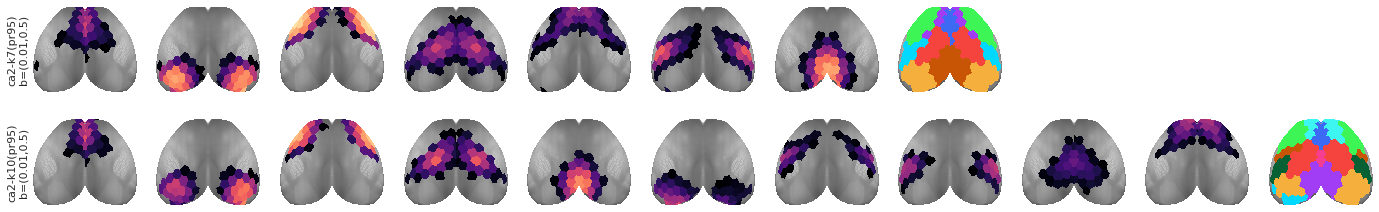

In [39]:
_ = quick_show(d2p, vmax=1.0, figsize=(24, 3.8), ylabel_fontsize=11)

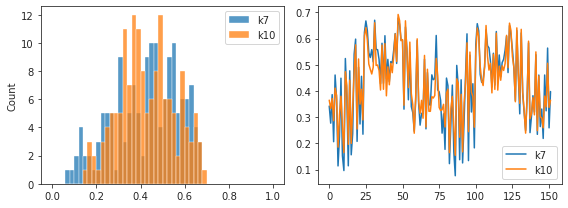

In [49]:
fig, axes = create_figure(1, 2, (8, 3.))

for i, (kk, h) in enumerate(ent_grp.items()):
    sns.histplot(h, bins=np.linspace(0, 1, 51), label=f"k{kk}", color=f'C{i}', ax=axes[0])
    axes[1].plot(h, label=f"k{kk}", color=f'C{i}')
for ax in axes.flat:
    ax.legend()
plt.show()

In [50]:
sp_stats.pearsonr(ent_grp[7], ent_grp[10])

(0.9604044529741587, 3.800829554597059e-85)

In [63]:
r_all = []
for i in range(120):
    x = ent_run[7].reshape(-1, ent_run[7].shape[-1])[i]
    y = ent_run[10].reshape(-1, ent_run[7].shape[-1])[i]
    good = np.logical_and(np.isfinite(x), np.isfinite(y))
    if not good.sum():
        continue
    r = sp_stats.pearsonr(x[good], y[good])[0]
    r_all.append(r)
len(r_all)

110

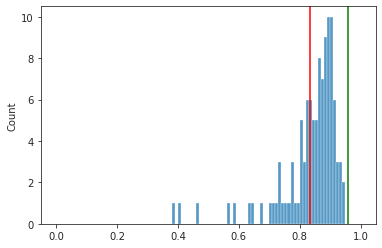

In [69]:
sns.histplot(r_all, bins=np.linspace(0, 1, 101))
plt.axvline(np.mean(r_all), color='r')
plt.axvline(sp_stats.pearsonr(ent_grp[7], ent_grp[10])[0], color='g')
plt.show()

## H

In [130]:
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)
props_ca = {'mode': 'ca2', **props_base}
gr_ca = Group(**props_ca).fit_group()
gr_ca.avg()

pr_ca = gr_ca.prune(n_resamples=int(7e3))
gr_ca.run_pi = pr_ca['pi_prune_run']
gr_ca.pi = pr_ca['pi_prune_avg']

h_ca_10 = sp_stats.entropy(gr_ca.run_pi, axis=-2) / np.log(gr_ca.num_k)
h_avg_ca_10 = bn.nanmean(bn.nanmean(bn.nanmean(h_ca_10, 2), 1), 0)
gr_ca.num_k

10

In [ ]:
"""b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)
props_ca = {'mode': 'ca2', **props_base}
props_ca['num_k'] += 1
gr_ca = Group(**props_ca).fit_group()
gr_ca.avg()

pr_ca = gr_ca.prune(n_resamples=int(7e3))
gr_ca.run_pi = pr_ca['pi_prune_run']
gr_ca.pi = pr_ca['pi_prune_avg']

h_ca_11 = sp_stats.entropy(gr_ca.run_pi, axis=-2) / np.log(gr_ca.num_k)
h_avg_ca_11 = bn.nanmean(bn.nanmean(bn.nanmean(h_ca_11, 2), 1), 0)
gr_ca.num_k"""

In [131]:
props_bo = {'mode': 'bold-lite', **props_base}
gr_bo = Group(**props_bo).fit_group()
pr_bo = gr_bo.prune(n_resamples=int(7e3), ci=0.95)
gr_bo.run_pi = pr_bo['pi_prune_run']
gr_bo.pi = pr_bo['pi_prune_avg']
# _ = gr_bo._merge_vis(0.05)

h_bo_10 = sp_stats.entropy(gr_bo.run_pi, axis=-2) / np.log(gr_bo.num_k)
h_avg_bo_10 = bn.nanmean(bn.nanmean(bn.nanmean(h_bo_10, 2), 1), 0)
gr_bo.num_k

10

In [8]:
props_bo = {'mode': 'bold-lite', **props_base}
props_bo['num_k'] += 1
gr_bo = Group(**props_bo).fit_group()
pr_bo = gr_bo.prune(n_resamples=int(7e3), ci=0.95)
gr_bo.run_pi = pr_bo['pi_prune_run']
gr_bo.pi = pr_bo['pi_prune_avg']
# _ = gr_bo._merge_vis(0.05)

h_bo_11 = sp_stats.entropy(gr_bo.run_pi, axis=-2) / np.log(gr_bo.num_k)
h_avg_bo_11 = bn.nanmean(bn.nanmean(bn.nanmean(h_bo_11, 2), 1), 0)
gr_bo.num_k

11

In [11]:
props_bo = {'mode': 'bold-lite', **props_base}
props_bo['num_k'] += 1
gr_bo = Group(**props_bo).fit_group()
pr_bo = gr_bo.prune(n_resamples=int(7e3), ci=0.95)
gr_bo.run_pi = pr_bo['pi_prune_run']
gr_bo.pi = pr_bo['pi_prune_avg']
_ = gr_bo._merge_vis(0.05)

h_bo_mg = sp_stats.entropy(gr_bo.run_pi, axis=-2) / np.log(gr_bo.num_k)
h_avg_bo_mg = bn.nanmean(bn.nanmean(bn.nanmean(h_bo_mg, 2), 1), 0)
gr_bo.num_k

10

In [136]:
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)
props_ca = {'mode': 'ca2', **props_base}
gr_ca = Group(**props_ca).fit_group()
gr_ca.run_pi = bn.nanmean(gr_ca.run_pi, -3)

h_ca_10 = sp_stats.entropy(gr_ca.run_pi, axis=-2) / np.log(gr_ca.num_k)
h_avg_ca_10 = bn.nanmean(bn.nanmean(bn.nanmean(h_ca_10, 2), 1), 0)
gr_ca.num_k

10

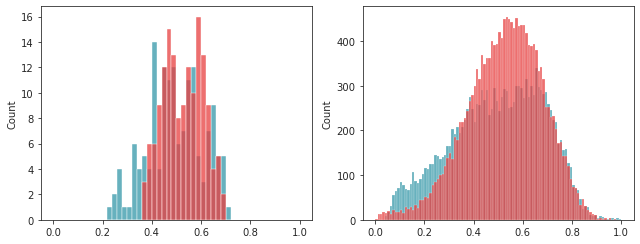

In [138]:
fig, axes = create_figure(1, 2, (9, 3.5))

sns.histplot(h_avg_ca_10, bins=np.linspace(0, 1, 51), color=pal['ca2'], ax=axes[0])
sns.histplot(h_avg_bo_10, bins=np.linspace(0, 1, 51), color=pal['bold-lite'], ax=axes[0])

sns.histplot(h_ca_10[h_ca_10.nonzero()], bins=np.linspace(0, 1, 101), color=pal['ca2'], ax=axes[1])
sns.histplot(h_bo_10[h_bo_10.nonzero()], bins=np.linspace(0, 1, 101), color=pal['bold-lite'], ax=axes[1])

plt.show()

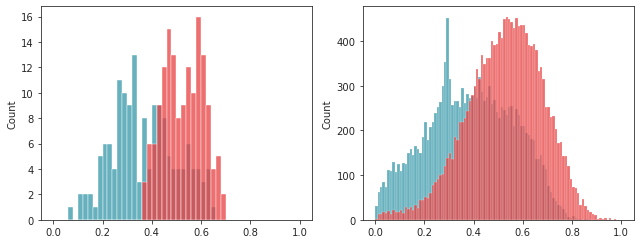

In [161]:
gr_ca.avg()
d2p[f'ca2(not-pr)\nb={b}'.replace(' ', '')] = gr_ca.trim2d(gr_ca.project_vec())

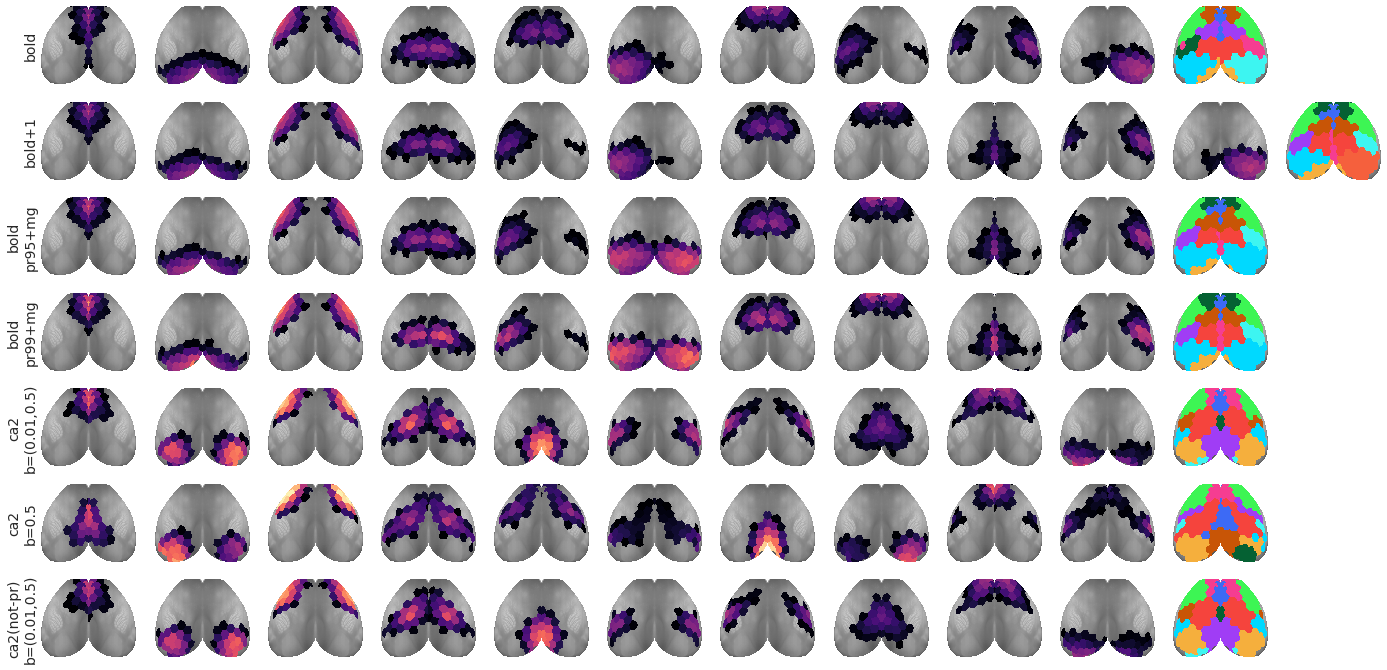

In [162]:
_ = quick_show(d2p, vmin=0.1, vmax=1.0, figsize=(24, 12), ylabel_fontsize=14)

<AxesSubplot:ylabel='Count'>

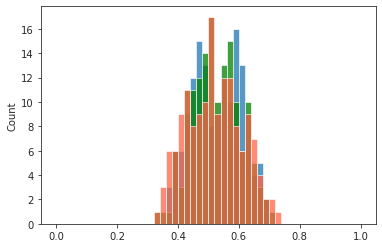

In [139]:
sns.histplot(h_avg_bo_10, bins=np.linspace(0, 1, 51))
sns.histplot(h_avg_bo_11, bins=np.linspace(0, 1, 51), color='g')
sns.histplot(h_avg_bo_mg, bins=np.linspace(0, 1, 51), color='tomato')

In [163]:
trh_ca_10 = gr_ca.trim2d(gr_bo.project_vec(h_avg_ca_10, add_disjoint=False))
trh_bo_10 = gr_ca.trim2d(gr_bo.project_vec(h_avg_bo_10, add_disjoint=False))
trh_bo_11 = gr_ca.trim2d(gr_bo.project_vec(h_avg_bo_11, add_disjoint=False))
trh_bo_mg = gr_ca.trim2d(gr_bo.project_vec(h_avg_bo_mg, add_disjoint=False))

vmin = min(np.nanmin(h_avg_ca_10), np.nanmin(h_avg_bo_10), np.nanmin(h_avg_bo_11), np.nanmin(h_avg_bo_mg))
vmax = max(np.nanmax(h_avg_ca_10), np.nanmax(h_avg_bo_10), np.nanmax(h_avg_bo_11), np.nanmax(h_avg_bo_mg))
kw_im = {
    'vmin': vmin,
    'vmax': vmax,
    'cmap': 'icefire',
}
vmin, vmax

(0.23037689538563905, 0.724035911433707)

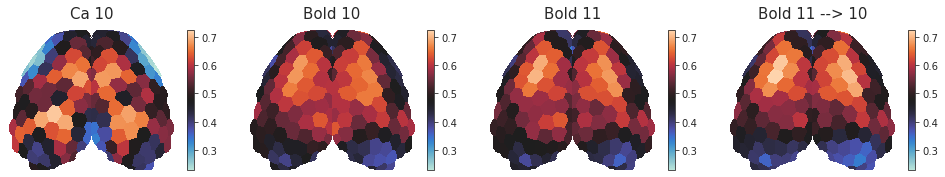

In [141]:
fig, axes = create_figure(1, 4, (13.5, 2.4))

im = axes[0].imshow(mwh(trh_ca_10['proj-top'][0] < vmin, trh_ca_10['proj-top'][0]), **kw_im)
axes[0].set_title('Ca 10', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(mwh(trh_bo_10['proj-top'][0] < vmin, trh_bo_10['proj-top'][0]), **kw_im)
axes[1].set_title('Bold 10', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(mwh(trh_bo_11['proj-top'][0] < vmin, trh_bo_11['proj-top'][0]), **kw_im)
axes[2].set_title('Bold 11', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[2])

im = axes[3].imshow(mwh(trh_bo_mg['proj-top'][0] < vmin, trh_bo_mg['proj-top'][0]), **kw_im)
axes[3].set_title('Bold 11 --> 10', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[3])

remove_ticks(axes)
plt.show()

In [142]:
sp_stats.pearsonr(h_avg_bo_10, h_avg_bo_mg)

(0.9207048579946774, 3.561061905557345e-63)

In [143]:
sp_stats.pearsonr(h_avg_bo_10, h_avg_bo_11)

(0.9580061746150019, 2.8609405138619793e-83)

In [144]:
sp_stats.pearsonr(h_avg_bo_mg, h_avg_bo_11)

(0.9634534518516699, 1.045062568998126e-87)

In [147]:
sp_stats.pearsonr(h_avg_bo_10, h_avg_ca_10)

(0.4332918165008459, 2.4652039288401117e-08)

In [148]:
sp_stats.pearsonr(h_avg_bo_mg, h_avg_ca_10)

(0.3801225500857732, 1.3629250608234312e-06)

### Conclusion: for entropy do not use mg, mg is just for visualization of communities
- For other statistics also do not use mg, just find out how to cut data from say num k = 11 and then somehow average the two communities to be mg-ed and that gives u a single number for that community

## Difference map

### ca_10 vs bo_10

In [149]:
y1 = h_bo_10.reshape(-1, h_bo_10.shape[-1])
y2 = h_ca_10.reshape(-1, h_ca_10.shape[-1])
y1.shape, y2.shape

((120, 152), (120, 152))

In [150]:
def statistic(a, b, axis):
    return bn.nanmean(a - b, axis=axis)

In [151]:
test = sp_stats.permutation_test(
    data=(y1, y2),
    statistic=statistic,
    permutation_type='samples',
    alternative='two-sided',
    n_resamples=int(1e3),
    vectorized=True,
    random_state=42,
    batch=5,
    axis=0,
)

In [152]:
tr_statistic = gr_ca.project_vec(test.statistic, add_disjoint=False, thres=-np.inf)
tr_pvalue = gr_ca.project_vec(test.pvalue, add_disjoint=False, thres=-np.inf)
tr_statistic = gr_ca.trim2d(tr_statistic)
tr_pvalue = gr_ca.trim2d(tr_pvalue)

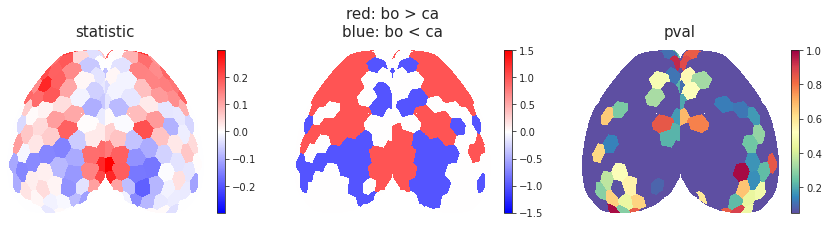

In [155]:
fig, axes = create_figure(1, 3, (12, 3))

alpha = 0.05

vminmax = np.max(np.abs(test.statistic))
im = axes[0].imshow(
    mwh(tr_statistic['top'] == 0, tr_statistic['proj-top'][0]),
    cmap='bwr', vmin=-vminmax, vmax=vminmax)
axes[0].set_title('statistic', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[0])

x = tr_statistic['proj-top'][0].copy()
x[x > 0] = 1
x[x < 0] = -1
x[tr_pvalue['proj-top'][0] > alpha] = 0
im = axes[1].imshow(
    mwh(tr_pvalue['top'] == 0.0, x),
    cmap='bwr', vmin=-1.5, vmax=1.5)
axes[1].set_title('red: bo > ca\nblue: bo < ca', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(
    mwh(tr_pvalue['top'] == 0, tr_pvalue['proj-top'][0]),
    cmap='Spectral_r', vmin=alpha, vmax=1)
axes[2].set_title('pval', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

### ca_10 vs bo_mg

In [156]:
y1 = h_bo_mg.reshape(-1, h_bo_mg.shape[-1])
y2 = h_ca_10.reshape(-1, h_ca_10.shape[-1])
y1.shape, y2.shape

((120, 152), (120, 152))

In [157]:
def statistic(a, b, axis):
    return bn.nanmean(a - b, axis=axis)

In [158]:
test = sp_stats.permutation_test(
    data=(y1, y2),
    statistic=statistic,
    permutation_type='samples',
    alternative='two-sided',
    n_resamples=int(1e3),
    vectorized=True,
    random_state=42,
    batch=5,
    axis=0,
)

In [159]:
tr_statistic = gr_ca.project_vec(test.statistic, add_disjoint=False, thres=-np.inf)
tr_pvalue = gr_ca.project_vec(test.pvalue, add_disjoint=False, thres=-np.inf)
tr_statistic = gr_ca.trim2d(tr_statistic)
tr_pvalue = gr_ca.trim2d(tr_pvalue)

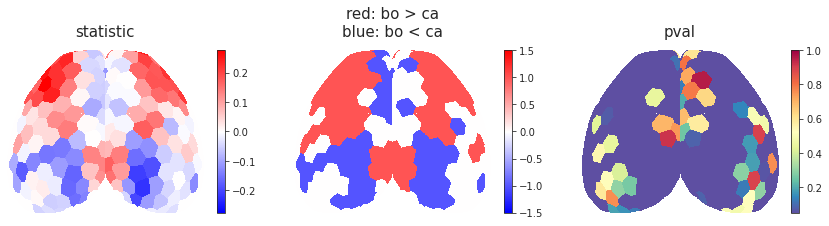

In [160]:
fig, axes = create_figure(1, 3, (12, 3))

alpha = 0.05

vminmax = np.max(np.abs(test.statistic))
im = axes[0].imshow(
    mwh(tr_statistic['top'] == 0, tr_statistic['proj-top'][0]),
    cmap='bwr', vmin=-vminmax, vmax=vminmax)
axes[0].set_title('statistic', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[0])

x = tr_statistic['proj-top'][0].copy()
x[x > 0] = 1
x[x < 0] = -1
x[tr_pvalue['proj-top'][0] > alpha] = 0
im = axes[1].imshow(
    mwh(tr_pvalue['top'] == 0.0, x),
    cmap='bwr', vmin=-1.5, vmax=1.5)
axes[1].set_title('red: bo > ca\nblue: bo < ca', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(
    mwh(tr_pvalue['top'] == 0, tr_pvalue['proj-top'][0]),
    cmap='Spectral_r', vmin=alpha, vmax=1)
axes[2].set_title('pval', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

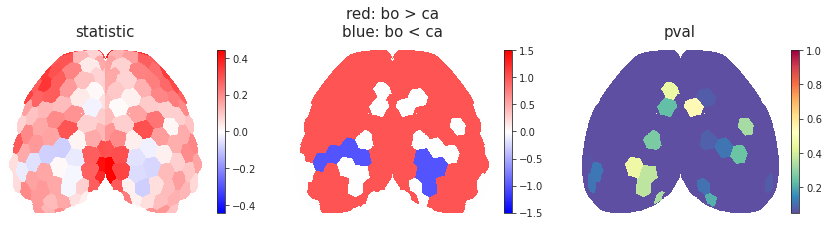

In [56]:
from statsmodels.stats.multitest import multipletests

<AxesSubplot:>

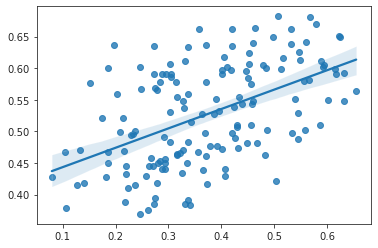

In [116]:
sns.regplot(h_avg_ca_10, h_avg_bo_10)

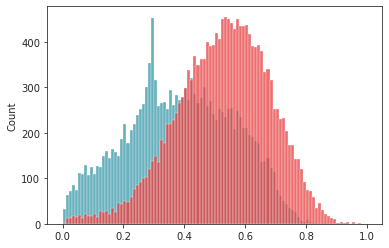